# Variable selection using lasso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from sklearn.model_selection import LeaveOneOut

Read the data

In [2]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Survival of multiple myeloma patients.dat", sep="\s+")
DatOriginal = DatOriginal.drop('patient', axis=1)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3594/843039072.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Survival of multiple myeloma patients.dat", sep="\s+")


In [ ]:
DatOriginal.head()

---

In [3]:
# Partial log-likelihood of a dataset using Breslow approximation and the beta-coefficients of a fit Cox PH
def LogLikelihood(cox, data):
    BetaTimesX = cox.predict_log_partial_hazard(data).values

    DeathTimes = data.loc[data['status']==1, 'time'].unique()
    Aux1, Aux2 = 0, 0
    for t in DeathTimes:
        ObsRisk = (data['time']>=t)
        ObsDeath = (data['time']==t) & (data['status']>=1)
        NumberDeaths = sum(ObsDeath)

        Aux1 += sum(ObsDeath * BetaTimesX)
        Aux2 += NumberDeaths * np.log(sum(ObsRisk * np.exp(BetaTimesX)))

    loglikelihood = Aux1 - Aux2
    return loglikelihood

---

In [4]:
LambdaList = np.linspace(0, 0.3)

CvEstimate = []
for l in LambdaList:
    CvMetric = []
    Loo = LeaveOneOut()
    
    for TrainIds, TestIds in Loo.split(DatOriginal):
        XTrain, XTest = DatOriginal.iloc[TrainIds], DatOriginal.iloc[TestIds]

        Model = CoxPHFitter(l1_ratio=1, penalizer=l)
        Model.fit(XTrain, "time", "status")

        LoglikeWhole = LogLikelihood(Model, DatOriginal)
        CvMetric.append(LoglikeWhole - Model.log_likelihood_)
    
    CvEstimate.append(sum(CvMetric))

/home/dmitri/.local/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


In [5]:
LambdaHat = LambdaList[np.argmax(CvEstimate)]

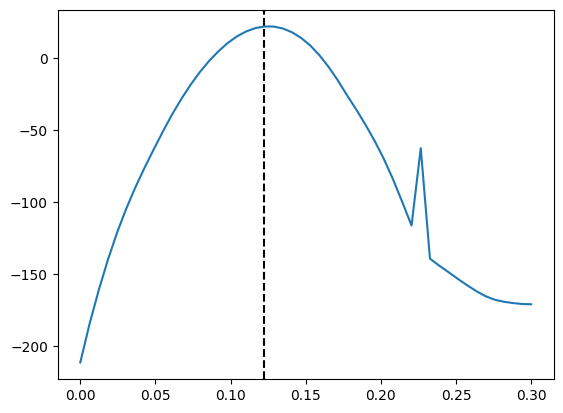

In [6]:
plt.plot(LambdaList, CvEstimate)
plt.axvline(LambdaHat, color='k', linestyle='--')

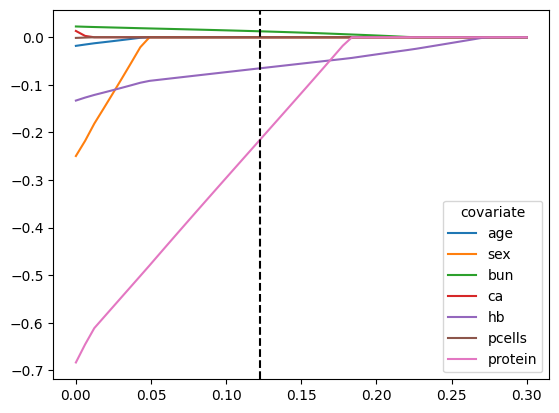

In [7]:
Params = {}

for l in LambdaList:
    Model = CoxPHFitter(l1_ratio=1, penalizer=l).fit(DatOriginal, "time", "status")
    Params[l] = Model.params_

pd.DataFrame(Params).T.plot()
plt.axvline(LambdaHat, color='k', linestyle='--')

In [8]:
Model = CoxPHFitter(l1_ratio=1, penalizer=LambdaHat).fit(DatOriginal, "time", "status")

In [10]:
Model.params_.round(3)

covariate
age       -0.000
sex       -0.000
bun        0.013
ca        -0.000
hb        -0.065
pcells     0.000
protein   -0.215
Name: coef, dtype: float64

We deduce from this analysis that we only need the variables bun, hb, and protein.